### Text Summarization using Pipelines and Summarization Transformer Models

* [Data Visualization & Analysis](#data-viz)
* [Summarization using Pipelines](#summarization-using-pipelines)
  1) [T5-BASE Model](#1-t5-base-summarization-model)
  2) [T5-LARGE Model](#2-t5-large-summarization-model)
  3) [BART-LARGE-CNN Model](#3-bart-large-cnn-model)
* [Loading Models Manually - More Parameters Control](#loading-models-manually---more-parameters-control)
* [Exploring `num_beans` Parameter](#explore-num_beans-parameter)
* [Apply Summarization to All Posts & Comments](#apply-summarization-to-all-posts--comments)



In [ ]:
%pip install transformers
%pip install tqdm

In [ ]:
# import statements
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('whitegrid')

In [3]:
from transformers import BartTokenizer
from transformers import pipeline
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [5]:
data = pd.read_csv("reddit_posts_nyc_apt_sentiment_roberta.csv", index_col=0)

In [ ]:
# Quick look at data
data.head(3)

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict,sentiment,sentiment_prob
0,r/NYCapartments,Midtown manhattan Studio with great view,1622,289,https://redd.it/1ditjh8,"['$5000 for a studio 😕', 'It comes with person...",$5000 for a studio 😕 it comes with personal tr...,"SequenceClassifierOutput(loss=None, logits=ten...","{'label': 'positive', 'prob': 0.5385751128196716}",positive,0.538575
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1434,57,https://redd.it/1at9s69,"['When can I move in?', 'Wow! What a steal!', ...",when can i move in? wow! what a steal! pets? 3...,"SequenceClassifierOutput(loss=None, logits=ten...","{'label': 'negative', 'prob': 0.529732346534729}",negative,0.529732
2,r/NYCapartments,Those with high rise skyline apartments do you...,1338,249,https://redd.it/1fwnevs,['I didn’t live in one but I worked at an offi...,i didn’t live in one but i worked at an office...,"SequenceClassifierOutput(loss=None, logits=ten...","{'label': 'positive', 'prob': 0.7256765961647034}",positive,0.725677


<a name="data-viz"></a>
### Data Visualization & Analysis

In [7]:
# keep only needed columns
data = data[['title','cleaned_text','score','num_comments','sentiment','sentiment_prob']]

In [8]:
# assign engagement - num comments and upvotes (score)
data = data.assign(engagement = data.score + data.num_comments)

In [9]:
data.head()

,title,cleaned_text,score,num_comments,sentiment,sentiment_prob,engagement
0,Midtown manhattan Studio with great view,$5000 for a studio 😕 it comes with personal tr...,1622,289,positive,0.538575,1911
1,"Spacious studio on the UWS, great location ste...",when can i move in? wow! what a steal! pets? 3...,1434,57,negative,0.529732,1491
2,Those with high rise skyline apartments do you...,i didn’t live in one but i worked at an office...,1338,249,positive,0.725677,1587
3,The rent crisis in NYC is becoming increasingl...,"two incomes no kids. tell me about it, i liter...",1256,371,negative,0.841027,1627
4,Happy Monday everyone,i think average salary context is needed. take...,944,199,negative,0.446637,1143


In [ ]:
# Sentiment scores
data.groupby('sentiment').score.describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,82.0,291.317073,249.756715,82.0,121.75,199.5,356.25,1434.0
neutral,46.0,210.282609,132.226180,85.0,110.25,164.5,275.00,697.0
positive,72.0,244.875000,243.842014,80.0,126.75,180.5,260.75,1622.0


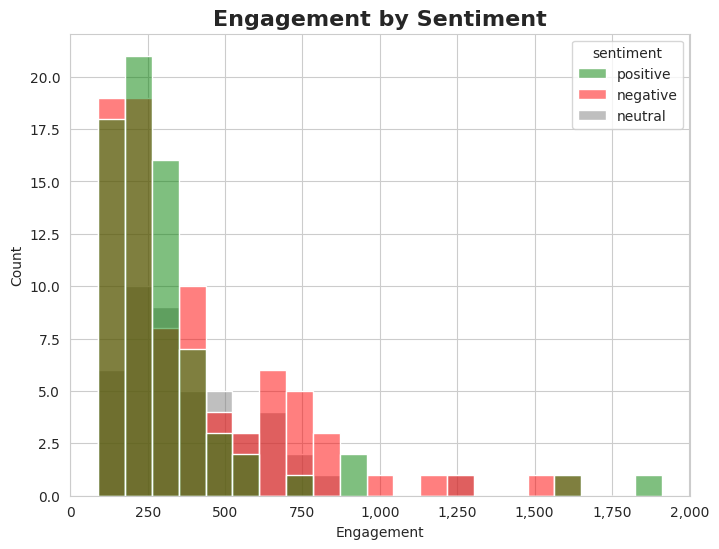

In [11]:
# create color palette
palette = sns.color_palette(["green", "red", "grey"])

# plot engagement and sentiment
fig, ax = plt.subplots(figsize = (8, 6))
g = sns.histplot(data=data, x='engagement', hue='sentiment', palette=palette,
                 ax=ax)
_ = ax.set_title('Engagement by Sentiment', fontdict={'fontsize': 16,
                                                      'fontweight': 'bold'})
_ = ax.set_xlabel('Engagement')
# Add commas to x-axis tick labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
_ = ax.set_ylabel('Count')


In [12]:
# Define the engagement threshold (75th percentile)
top_25_threshold = data.engagement.quantile(0.75)

# Filter for top 25% most engaging posts
top_engagement_posts = data[data.engagement >= top_25_threshold]

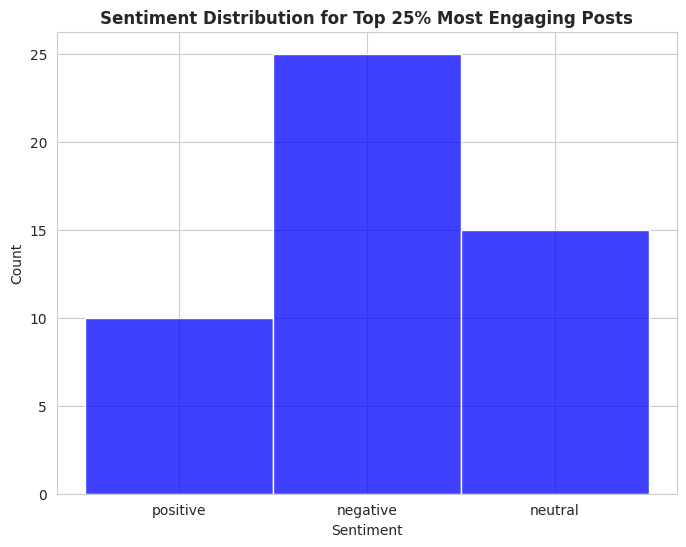

In [13]:
# Plot sentiment distribution for high-engagement posts
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(top_engagement_posts, x='sentiment', color='blue', ax=ax)

# Format plot
ax.set_title('Sentiment Distribution for Top 25% Most Engaging Posts',
              fontsize=12, fontweight='bold')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

In [ ]:
# sample 20 comments for summarization
df_sample = data.sample(n=20, random_state=23)
# sample 1 comment
sample_comment = df_sample.cleaned_text.iloc[2]

In [15]:
print(sample_comment)

is the building or most of the units in the building rent stabilized? i knew someone that lived in that building 10 years ago. it was a dump with questionable management (although i don't know if it was the same ownership and management) then and it hasn't gotten better with age. guessing they're still coasting on the reputation of the beat generation. i fell in love with someone on that roof pretty common wiring set up in most buildings. and is that flood water outside the building anyways? i’m confused here. the address rules..! … kind of like bragging rights…! those are cable company wires and moldings. they have to fix it not the management. bidding yourself into a $6k “deathtrap” then begging the city the come help is a perfect definition of “play stupid games win stupid prizes”  and we all know if they actually fix it up obviously someone with a little more standards is going to pay $8k for it [deleted]


<a name="summarization-using-pipelines"></a>
### Summarization using Pipelines

<a name="1-t5-base-summarization-model"></a>
#### 1) T5-BASE Summarization Model

In [ ]:
# summarize just one comment using t5-base
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base")
summary = summarizer(sample_comment, min_length=5, max_length=200,
                     do_sample=False)

In [17]:
print(summary[0]['summary_text'])

the address rules are kind of like bragging rights...! those are cable company wires and moldings. they have to fix it not the management . bidding yourself into a $6k "deathtrap" then begging the city to come help is a perfect definition of "play stupid games win stupid prizes"


<a name="2-t5-large-summarization-model"></a>
#### 2) T5-LARGE Summarization Model

In [ ]:
# summarize just one comment using t5-large
summarizer = pipeline("summarization", model="t5-large", tokenizer="t5-large")
summary = summarizer(sample_comment, min_length=5, max_length=200,
                     do_sample=False)

In [19]:
# let's look at the result
summary[0]['summary_text']

'is the building or most of the units in the building rent stabilized? i knew someone that lived in that building 10 years ago. it was a dump with questionable management . i fell in love with someone on that roof pretty common wiring set up in most buildings .'

<a name="3-bart-large-cnn-model"></a>
#### 3) BART-LARGE-CNN Model

In [ ]:
# Load summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Load the tokenizer separately to enable manual truncation
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

summary = summarizer(sample_comment, min_length=30, max_length=100,
                     do_sample=False)

# do_sample=False makes the summarization deterministic
# meaning it will always return the same summary for the same input.

In [21]:
print(summary[0]['summary_text'])

Is the building or most of the units in the building rent stabilized? i knew someone that lived in that building 10 years ago. it was a dump with questionable management (although i don't know if it was the same ownership and management) then and it hasn't gotten better with age. guessing they're still coasting on the reputation of the beat generation. i fell in love with someone on that roof pretty common wiring set up in most buildings.


<a name="loading-models-manually---more-parameters-control"></a>
### Loading Models Manually - More Parameters Control

In [22]:
# Load model and tokenizer (T5-base example)
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [23]:
# Add "summarize:" prefix for T5 models
input_text = "summarize: " + sample_comment

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512,
                             truncation=True)

In [24]:
tokenizer.decode(input_ids[0])

"summarize: is the building or most of the units in the building rent stabilized? i knew someone that lived in that building 10 years ago. it was a dump with questionable management (although i don't know if it was the same ownership and management) then and it hasn't gotten better with age. guessing they're still coasting on the reputation of the beat generation. i fell in love with someone on that roof pretty common wiring set up in most buildings. and is that flood water outside the building anyways? i’m confused here. the address rules..! ... kind of like bragging rights...! those are cable company wires and moldings. they have to fix it not the management. bidding yourself into a $6k “deathtrap” then begging the city the come help is a perfect definition of “play stupid games win stupid prizes” and we all know if they actually fix it up obviously someone with a little more standards is going to pay $8k for it [deleted]</s>"

In [25]:
# Generate summary using .generate()
summary_ids = model.generate(input_ids, min_length=30, max_length=100,
            length_penalty=2.0, num_beams=4)

# Decode the output
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
print(summary)

the address rules are kind of like bragging rights...! those are cable company wires and moldings. they have to fix it not the management. bidding yourself into a $6k "deathtrap" then begging the city to come help is a perfect definition of "play stupid games win stupid prizes"


<a name="explore-num_beans-parameter"></a>
### Explore `num_beans` parameter

In [26]:
# Generate text with different beam sizes

# Greedy search
output_1 = model.generate(input_ids, num_beams=1,
                          min_length=30, max_length=100)
# Beam search with 4 beams
output_4 = model.generate(input_ids, num_beams=4,
                          min_length=30, max_length=100)
# Beam search with 8 beams
output_8 = model.generate(input_ids, num_beams=8,
                          min_length=30, max_length=100)

# Decode outputs
print("Greedy Search:", tokenizer.decode(output_1[0],
                                         skip_special_tokens=True))
print("Beam Search (4 beams):", tokenizer.decode(output_4[0],
                                                 skip_special_tokens=True))
print("Beam Search (8 beams):", tokenizer.decode(output_8[0],
                                                 skip_special_tokens=True))

Greedy Search: john sutter: i'm confused here. the address rules..! those are cable company wires and moldings. they have to fix it not the management . sutter: i'm sure if the city fixes it up someone with a little more standards is going to pay $8k for it .
Beam Search (4 beams): the address rules are kind of like bragging rights...! those are cable company wires and moldings. they have to fix it not the management . bidding yourself into a $6k "deathtrap" then begging the city to come help is a perfect definition of "play stupid games win stupid prizes"
Beam Search (8 beams): the address rules are kind of like bragging rights...! those are cable company wires and moldings. they have to fix it not the management . bidding yourself into a $6k "deathtrap" then begging the city to come help is a perfect definition of "play stupid games win stupid prizes"


In [27]:
# Load summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Load the tokenizer separately to enable manual truncation
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

Device set to use cuda:0


In [28]:
def summarize_text_with_bart(text: str, min_length: int = 30,
                             max_length: int = 100) -> str:
    """
    Summarizes a given text using the BART model while handling truncation
    issues.

    This function:
    - Uses `facebook/bart-large-cnn` for summarization.
    - Truncates text to 1024 tokens before summarization to avoid exceeding
    model limits.
    - Ensures deterministic summaries: disables sampling (`do_sample=False`).
    - Handles empty/NaN inputs: returns an empty string.


    Parameters:
    -----------
    text : str
        The input text to summarize. Should be a non-empty string.
    min_length: int
        Minimum length of summary output
    max_length: int
        Maximum length of summary output

    Returns:
    --------
    summary_text : str
        The summarized version of the input text.
    """

    # Load summarization pipeline
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    # Load tokenizer for manual truncation
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

    # Handle empty or NaN input
    if pd.isna(text) or text.strip() == "":
        return ""

    # Tokenize and truncate if necessary
    inputs = tokenizer(
        text,
        max_length=1024,
        truncation=True,
        return_tensors="pt",
    )

    # Move inputs to the same device as the model
    inputs = inputs.to(summarizer.device)

    # Generate the summary
    summary_ids = summarizer.model.generate(
        **inputs,
        max_length=max_length,  # Control output length
        min_length=min_length,
        do_sample=False  # Ensures deterministic output
    )

    # Decode the summary, skipping special tokens
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary_text


In [29]:
data.head(3)

,title,cleaned_text,score,num_comments,sentiment,sentiment_prob,engagement
0,Midtown manhattan Studio with great view,$5000 for a studio 😕 it comes with personal tr...,1622,289,positive,0.538575,1911
1,"Spacious studio on the UWS, great location ste...",when can i move in? wow! what a steal! pets? 3...,1434,57,negative,0.529732,1491
2,Those with high rise skyline apartments do you...,i didn’t live in one but i worked at an office...,1338,249,positive,0.725677,1587


<a name="apply-summarization-to-all-posts--comments"></a>
### Apply Summarization to All Posts & Comments

In [ ]:
start_time = time.time()

# Apply the summarization function to the DataFrame with tqdm
tqdm.pandas() # Initialize tqdm for pandas - adds progress_apply to pandas
data["summary"] = data["cleaned_text"].progress_apply(summarize_text_with_bart)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
print(f"Time taken: {(end_time - start_time)/60} mins")

In [31]:
data.head(2)

,title,cleaned_text,score,num_comments,sentiment,sentiment_prob,engagement,summary
0,Midtown manhattan Studio with great view,$5000 for a studio 😕 it comes with personal tr...,1622,289,positive,0.538575,1911,$5000 for a studio with personal training from...
1,"Spacious studio on the UWS, great location ste...",when can i move in? wow! what a steal! pets? 3...,1434,57,negative,0.529732,1491,"No doorman, and it's a walk up. natural light,..."


In [32]:
# print a few random posts & summaries
for ix, i in data.sample(n=5, random_state=23).iterrows():
    print(f"\ntext: {i['cleaned_text']}")
    print(f"summary: {i['summary']}")


text: [just a warning to those interested](https://i.imgur.com/vrcda17.png) what bar in pps has a dj? if the deal is too good to be true, it's usually because the neighbors are noisy, the commute is ass, or building managers are absolutely horrible query:  do you sleep in the living room because it it too loud to be in your bedroom? great deal, thanks for posting here! if you get a noise meter it is possible to get 311 involved to shut down the dj. i love in pps, what is the name of the bar? wow! what a deal moving out due to noise from bar in back yard. too much for me but it might not be a problem for you you’re getting a lot of shit op but you’re right. some people can handle the noise with no problem. just because it’s not right for you doesn’t mean it’s not for others as long as the person knows what they’re getting into then people should stop scaring people off this. maybe the person works nights, maybe they want to go to the bar and party, every situation is different. is it l

In [33]:
data.to_csv('reddit_posts_summarized_Bart.csv')